
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 機械翻訳用のエンコーダ/デコーダ Seq2Seq

 :ラベル: `sec_seq2seq`

機械翻訳 (:numref: `sec_machine_translation`で説明) のような、いわゆる seq2seq 問題では、入力と出力の両方が可変長のアライメントされていないシーケンスで構成され、一般にエンコーダー-デコーダー アーキテクチャ (:numref: `sec_encoder-decoder` ) に依存します。このセクションでは、エンコーダとデコーダの両方が RNN として実装されているエンコーダ/デコーダ アーキテクチャを機械翻訳のタスクに適用する方法を示します (引用: `Sutskever.Vinyals.Le.2014,Cho.Van-Merrienboer.Gulcehre.ea.2014` 。

ここで、エンコーダ RNN は可変長シーケンスを入力として受け取り、それを固定形状の隠れ状態に変換します。この後の :numref: `chap_attention-and-transformers`では、入力全体を単一の固定長表現に圧縮することなく、エンコードされた入力にアクセスできるようにするアテンション メカニズムを導入します。

次に、出力シーケンスを一度に 1 トークンずつ生成するために、別個の RNN で構成されるデコーダー モデルが、入力シーケンスと出力内の先行トークンの両方を考慮して、連続する各ターゲット トークンを予測します。トレーニング中、デコーダーは通常、公式の「グラウンドトゥルース」ラベル内の先行トークンに基づいて条件付けされます。ただし、テスト時には、既に予測されたトークンに基づいてデコーダーの各出力を条件付けする必要があります。エンコーダを無視すると、seq2seq アーキテクチャのデコーダは通常の言語モデルとまったく同様に動作することに注意してください。 :numref: `fig_seq2seq`機械翻訳におけるシーケンス間の学習に 2 つの RNN を使用する方法を示しています。 

![](http://d2l.ai/_images/seq2seq.svg) :ラベル: `fig_seq2seq`

 :numref: `fig_seq2seq`では、特別な「&amp;lt;eos&amp;gt;」トークンはシーケンスの終わりを示します。このトークンが生成されると、モデルは予測を停止する可能性があります。 RNN デコーダの最初のタイム ステップでは、注意すべき特別な設計上の決定が 2 つあります。まず、すべての入力を特別なシーケンスの開始「&amp;lt;bos&amp;gt;」で開始します。トークン。 2 番目に、単一のデコード タイム ステップごとにエンコーダの最終的な隠れ状態をデコーダにフィードすることができます (引用: `Cho.Van-Merrienboer.Gulcehre.ea.2014` )。 :citet: `Sutskever.Vinyals.Le.2014`などの他の設計では、RNN エンコーダーの最終的な隠し状態は、最初のデコード ステップでのみデコーダーの隠し状態を開始するために使用されます。


In [1]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


## 教師の強制

入力シーケンスでエンコーダーを実行するのは比較的簡単ですが、デコーダーの入力と出力を処理する方法にはさらに注意が必要です。最も一般的なアプローチは、*教師強制*と呼ばれることもあります。ここでは、元のターゲット シーケンス (トークン ラベル) が入力としてデコーダーに供給されます。より具体的には、特殊なシーケンス開始トークンと、最後のトークンを除く元のターゲット シーケンスがデコーダーへの入力として連結されますが、デコーダーの出力 (トレーニング用のラベル) は、元のターゲット シーケンスを 1 トークン分シフトしたものになります。 "&amp;lt;bos&gt;"、"Ils"、"regardent"、"." $\rightarrow$ "Ils"、"regardent"、"."、"&amp;lt;eos&amp;gt;" (:numref: `fig_seq2seq` )。

 :numref: `subsec_loading-seq-fixed-len`での実装は、教師強制用のトレーニング データを準備しました。ここで、自己教師あり学習のためのトークンのシフトは、 :numref: `sec_language-model`での言語モデルのトレーニングに似ています。別のアプローチは、前のタイム ステップからの*予測*トークンを現在の入力としてデコーダーに供給することです。

以下では、:numref: `fig_seq2seq`に示されている設計について詳しく説明します。 :numref: `sec_machine_translation`で紹介されているように、英語とフランス語のデータセットで機械翻訳用にこのモデルをトレーニングします。

## エンコーダ

エンコーダは可変長の入力シーケンスを固定形状の*コンテキスト変数*$\mathbf{c}$ に変換することを思い出してください (:numref: `fig_seq2seq`を参照)。

単一シーケンスの例 (バッチ サイズ 1) を考えてみましょう。入力シーケンスが $x_1, \ldots, x_T$ であり、$x_t$ が $t^{\mathrm{th}}$ トークンであるとします。タイム ステップ $t$ で、RNN は $x_t$ の入力特徴ベクトル $\mathbf{x}_t$ と前のタイム ステップの隠れ状態 $\mathbf{h} _{t-1}$ を次のタイム ステップに変換します。現在の非表示状態 $\mathbf{h}_t$。関数 $f$ を使用して、RNN のリカレント層の変換を表現できます。

 $$\mathbf{h} *t = f(\mathbf{x}_t, \mathbf{h}* {t-1})。 $$

一般に、エンコーダーは、カスタマイズされた関数 $q$ を通じて、すべてのタイム ステップの隠れ状態をコンテキスト変数に変換します。

 $$\mathbf{c} = q(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

たとえば、 :numref: `fig_seq2seq`では、コンテキスト変数は、入力シーケンスの最後のトークンを処理した後のエンコーダー RNN の表現に対応する隠れ状態 $\mathbf{h}_T$ です。

この例では、一方向 RNN を使用してエンコーダーを設計しました。ここで、隠れ状態は、隠れ状態のタイム ステップ以前の入力サブシーケンスにのみ依存します。双方向 RNN を使用してエンコーダを構築することもできます。この場合、隠れ状態はタイム ステップの前後のサブシーケンス (現在のタイム ステップでの入力を含む) に依存し、シーケンス全体の情報がエンコードされます。

それでは [ **RNN エンコーダを実装**] してみましょう。*埋め込み層*を使用して、入力シーケンス内の各トークンの特徴ベクトルを取得することに注意してください。埋め込み層の重みは行列であり、行数は入力語彙のサイズ ( `vocab_size` ) に対応し、列数は特徴ベクトルの次元 ( `embed_size` ) に対応します。入力トークン インデックス $i$ に対して、埋め込み層は重み行列の $i^{\mathrm{th}}$ 行 (0 から始まる) をフェッチして、その特徴ベクトルを返します。ここでは、マルチレイヤ GRU を使用してエンコーダを実装します。


In [2]:
def init_seq2seq(module):  #@save
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

In [3]:
class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state


具体的な例を使用して、**上記のエンコーダの実装を説明しましょう。** ] 以下では、隠れユニットの数が 16 である 2 層 GRU エンコーダをインスタンス化します。シーケンス入力`X`のミニバッチ (バッチ サイズ: 4、タイム ステップ数: 9) が与えられると、すべての層における最後の層の隠れ状態は次のようになります。タイム ステップ (エンコーダの再帰層によって返される`enc_outputs` ) は、形状のテンソル (タイム ステップ数、バッチ サイズ、隠れユニットの数) です。


In [4]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))


ここでは GRU を使用しているため、最終タイム ステップでの多層隠れ状態の形状は (隠れ層の数、バッチ サイズ、隠れユニットの数) になります。


In [5]:
d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))


## [**デコーダ**]

 :label: `sec_seq2seq_decoder`

各タイム ステップ $t&#39;$ のターゲット出力シーケンス $y_1, y_2, \ldots, y_{T&#39;}$ が与えられると (入力シーケンスのタイム ステップと区別するために $t^\prime$ を使用します)、デコーダはターゲット $y_1、\ldots、y_{t&#39;}$ およびコンテキスト変数 $\mathbf{c}$ 内の以前のトークンを条件として、ステップ $y_{t&#39;+1}$ で発生する可能性のある各トークンの予測確率、つまり、$P(y_{t&#39;+1} \mid y_1, \ldots, y_{t&#39;}, \mathbf{c})$ となります。

ターゲット シーケンス内の後続のトークン $t^\prime+1$ を予測するために、RNN デコーダーは前のステップのターゲット トークン $y_{t^\prime}$、つまり前のタイム ステップの隠れた RNN 状態 $\mathbf{ *s} {t^\prime-1}$、およびコンテキスト変数 $\mathbf{c}$ を入力とし、現在の隠れ状態 $\mathbf{s} {t^\prime}$ に変換します。*タイムステップ。関数 $g$ を使用して、デコーダの隠れ層の変換を表現できます。

 $$\mathbf{s} *{t^\prime} = g(y* {t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$ :eqlabel: `eq_seq2seq_s_t`

デコーダーの隠れ状態を取得した後、出力層とソフトマックス演算を使用して予測分布 $p(y_{t^{\prime}+1} \mid y_1, \ldots, y_{t^\) を計算できます。 prime}, \mathbf{c})$ を後続の出力トークン ${t^\prime+1}$ に置き換えます。

 :numref: `fig_seq2seq`に続いて、次のようにデコーダを実装するとき、エンコーダの最終タイム ステップで隠れ状態を直接使用して、デコーダの隠れ状態を初期化します。これには、RNN エンコーダーと RNN デコーダーが同じ数の層と隠れユニットを持つ必要があります。エンコードされた入力シーケンス情報をさらに組み込むために、コンテキスト変数はすべてのタイム ステップでデコーダ入力と連結されます。出力トークンの確率分布を予測するには、全結合層を使用して、RNN デコーダーの最終層で隠れ状態を変換します。


In [6]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]


[**実装されたデコーダを説明する**]ために、以下では、前述のエンコーダからの同じハイパーパラメータを使用してデコーダをインスタンス化します。見てわかるように、デコーダーの出力形状は (バッチ サイズ、タイム ステップ数、語彙サイズ) となり、テンソルの最後の次元には予測されたトークン分布が格納されます。


In [7]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))


要約すると、上記の RNN エンコーダー/デコーダー モデルのレイヤーは :numref: `fig_seq2seq_details`に示されています。 

![](../img/seq2seq-details.svg) :label: `fig_seq2seq_details`

## シーケンス間学習のためのエンコーダ/デコーダ

これらをすべてコードにまとめると、次のようになります。


In [8]:
class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder-decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)


## マスキングを使用した損失関数

各タイム ステップで、デコーダは出力トークンの確率分布を予測します。言語モデリングと同様に、ソフトマックスを適用して分布を取得し、最適化のためにクロスエントロピー損失を計算できます。 :numref: `sec_machine_translation`を思い出してください。特殊なパディング トークンがシーケンスの最後に追加されるため、さまざまな長さのシーケンスを同じ形状のミニバッチに効率的にロードできます。ただし、パディングトークンの予測は損失計算から除外する必要があります。この目的のために、無関係な予測とゼロの乗算がゼロになるように、[**無関係なエントリをゼロ値でマスクする**] ことができます。


In [9]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()


## 【**トレーニング**】

 :label: `sec_seq2seq_training`

これで、機械翻訳データセットでのシーケンス間学習のために [ **RNN エンコーダー/デコーダー モデルを作成してトレーニングする**] ことができるようになりました。


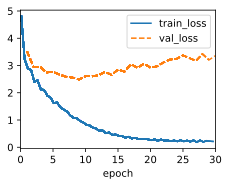

In [10]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)


## [**予測**]

各ステップで出力シーケンスを予測するには、前のタイム ステップからの予測トークンが入力としてデコーダーに供給されます。 1 つの簡単な戦略は、各ステップで予測するときにデコーダーが最も高い確率を割り当てたトークンをサンプリングすることです。トレーニングの場合と同様、最初のタイム ステップでシーケンスの開始 (「&amp;lt;bos&amp;gt;」) トークンがデコーダに供給されます。この予測プロセスは、 :numref: `fig_seq2seq_predict`に示されています。シーケンスの終わり (「&lt;eos&gt;」) トークンが予測されると、出力シーケンスの予測が完了します。 

![](../img/seq2seq-predict.svg) :label: `fig_seq2seq_predict`

次のセクションでは、ビーム検索 (:numref: `sec_beam-search` ) に基づいた、より洗練された戦略を紹介します。


In [11]:
@d2l.add_to_class(d2l.EncoderDecoder)  #@save
def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights


## 予測シーケンスの評価

予測されたシーケンスをターゲット シーケンス (グラウンド トゥルース) と比較することで評価できます。しかし、2 つの配列間の類似性を比較するための適切な尺度は正確には何でしょうか?

 BLEU (Bilingual Evaluation Understudy) は、もともと機械翻訳の結果を評価するために提案されました :cite: `Papineni.Roukos.Ward.ea.2002`が、さまざまなアプリケーションの出力シーケンスの品質を測定するために広く使用されています。原則として、BLEUは、予測配列内の$n$-gramについて、この$n$-gramがターゲット配列に出現するかどうかを評価します。

 $p_n$ は $n$-gram の精度を示します。これは、予測配列内の $n$-gram の数に対する、予測配列とターゲット配列内で一致した $n$-gram の数の比率です。説明すると、ターゲット シーケンス $A$、$B$、$C$、$D$、$E$、$F$、および予測シーケンス $A$、$B$、$B$、$C$ が与えられたとします。 , $D$ とすると、$p_1 = 4/5$、$p_2 = 3/4$、$p_3 = 1/3$、$p_4 = 0$ となります。さらに、$\mathrm{len} *{\text{label}}$ と $\mathrm{len}* {\text{pred}}$ をそれぞれターゲット配列と予測配列内のトークンの数とする。この場合、BLEU は次のように定義されます。

 $$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len} *{\text{label}}}{\mathrm{len} {* \text{pred}}}\right)\右) \prod_{n=1}^k p_n^{1/2^n},$$ :eqlabel: `eq_bleu`

ここで、$k$ はマッチングのための最長の $n$-gram です。

 :eqref: `eq_bleu`の BLEU の定義に基づいて、予測されたシーケンスがターゲット シーケンスと同じである場合、BLEU は 1 になります。さらに、長い $n$-gram のマッチングはより困難であるため、BLEU は長い $n$-gram に大きな重みを割り当てます。 $n$ グラムの精度。具体的には、$p_n$を固定した場合、$n$の成長に応じて$p_n^{1/2^n}$も増加します（元の論文では$p_n^{1/n}$を使用しています）。さらに、より短いシーケンスを予測すると、より高い $p_n$ 値が得られる傾向があるため、:eqref: `eq_bleu`乗算項の前の係数は、より短い予測シーケンスにペナルティを与えます。たとえば、$k=2$ の場合、ターゲット シーケンス $A$、$B$、$C$、$D$、$E$、$F$ と予測シーケンス $A$、$B$ が与えられますが、 $p_1 = p_2 = 1$、ペナルティ係数 $\exp(1-6/2) \約 0.14$ により BLEU が低下します。

当社では以下の通り**BLEU対策を実施しております**。


In [12]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score


最後に、トレーニングされた RNN エンコーダ/デコーダを使用して [**いくつかの英語の文をフランス語に翻訳**] し、結果の BLEU を計算します。


In [13]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['nous', '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000



## まとめ

エンコーダ/デコーダ アーキテクチャの設計に従って、2 つの RNN を使用してシーケンス間学習のモデルを設計できます。エンコーダ/デコーダ トレーニングでは、教師強制アプローチにより、(予測とは対照的に) 元の出力シーケンスがデコーダに供給されます。エンコーダとデコーダを実装するときは、多層 RNN を使用できます。マスクを使用すると、損失を計算する場合など、無関係な計算を除外できます。出力配列の評価に関しては、予測配列とターゲット配列の間で $n$-gram を照合する BLEU が一般的な手法です。

## 演習
1. ハイパーパラメータを調整して翻訳結果を改善できますか?
1. 損失計算でマスクを使用せずに実験を再実行します。どのような結果が観察されましたか?なぜ？
1. エンコーダとデコーダのレイヤ数や隠れユニットの数が異なる場合、デコーダの隠れ状態を初期化するにはどうすればよいでしょうか?
1. トレーニングでは、教師による強制を、前のタイム ステップでの予測をデコーダーに入力することで置き換えます。これはパフォーマンスにどのような影響を与えますか?
1.  GRU を LSTM に置き換えて実験を再実行します。
1. デコーダーの出力層を設計する他の方法はありますか?



[ディスカッション](https://discuss.d2l.ai/t/1062)
